In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import glob
import argparse
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from asreview import open_state
from asreviewcontrib.insights.plot import plot_recall
from asreviewcontrib.insights.plot import _recall_values
from asreviewcontrib.insights.utils import pad_simulation_labels
import asreviewcontrib.insights.metrics as met
from langdetect import detect
import pylab

In [62]:
state_files = "./state_files/pk{}_sim_Hamilton_{}_{}_{}_0.asreview"
prior_knowledge = ['1','2']
classifiers = ['logistic', 'svm']
csv_file = "./data/Hamilton_{}.csv"
datasets = ['Original', 'English', 'Multi_1', 'Multi_2']
models = ['tfidf', 'sbert', 'mbert', 'muse', 'mlongt5', 'labse', 'laser', 'mpnet', 'minilm', 'stsb']

In [4]:
language_dfs = {}
for dataset in datasets:
    languages = pd.read_csv(csv_file.format(dataset))
    languages['language'] = languages['abstract'].dropna().apply(detect)
    languages.columns.values[0] = 'record_id'
    language_dfs[dataset] = languages

# Dataset descriptives

In [6]:
data_descriptives = pd.read_csv("./data/data_descriptives.csv")
data_descriptives.head()

Unnamed: 0  n_records  n_relevant  n_irrelevant  \
0   data_stats_Hamilton_English.json       1859          87          1772   
1   data_stats_Hamilton_Multi_1.json       1859          87          1772   
2   data_stats_Hamilton_Multi_2.json       1859          87          1772   
3  data_stats_Hamilton_Original.json       1859          87          1772   

   n_unlabeled  n_missing_title  n_missing_abstract  n_duplicates  
0            0                5                 305             9  
1            0                5                 305             9  
2            0                5                 305             9  
3            0                5                 305             9

## Metrics

In [5]:
metrics_df = pd.DataFrame()
for prior in prior_knowledge:
    for classifier in classifiers:
        for dataset in datasets:
            for model in models:
                row = {'Dataset':dataset, 'Classifier':classifier, 'Model':model, 'Prior':prior}
                with open_state(state_files.format(prior, dataset, classifier, model)) as state:
                    metrics = met.get_metrics(state)
                    for item in metrics['data']['items']:
                        if item.get('title') == 'Time to discovery':
                            for paper_td in item.get('value'):
                                if paper_td[0] in [300, 567, 741, 878, 1112]:
                                    row['td_'+str(paper_td[0])] = paper_td[1]
                        elif type(item.get('value')) != list:
                            row[item.get('title')] = item.get('value')
                        else:
                            for value in item.get('value'):
                                row[str(item.get('title'))+'_'+str(value[0])] = value[1]
                metrics_df = metrics_df.append(row, ignore_index = True)
metrics_df

Average time to discovery Classifier   Dataset  \
0                   144.593023   logistic  Original   
1                   114.558140   logistic  Original   
2                   229.337209   logistic  Original   
3                   114.860465   logistic  Original   
4                   239.383721   logistic  Original   
..                         ...        ...       ...   
155                 156.011628        svm   Multi_2   
156                 241.209302        svm   Multi_2   
157                 216.534884        svm   Multi_2   
158                 274.186047        svm   Multi_2   
159                 203.558140        svm   Multi_2   

     Extra Relevant record Found_0.1    Model Prior  Recall_0.1  Recall_0.25  \
0                           0.674419    tfidf     1    0.779070     0.930233   
1                           0.779070    sbert     1    0.883721     0.965116   
2                           0.465116    mbert     1    0.569767     0.872093   
3                           0.709302     muse     1    0.813953     0.976744   
4                           0.372093  mlongt5     1    0.476744     0.872093   
..                               ...      ...   ...         ...          ...   
155                         0.604651    labse     2    0.709302     0.930233   
156                         0.453488    laser     2    0.558140     0.837209   
157                         0.534884    mpnet     2    0.639535     0.883721   
158                         0.372093   minilm     2    0.476744     0.825581   
159                         0.488372     stsb     2    0.593023     0.895349   

     Recall_0.5  Recall_0.75  Recall_0.9  Work Saved over Sampling_0.95  \
0      1.000000     1.000000         1.0                       0.639203   
1      0.988372     1.000000         1.0                       0.819602   
2      0.988372     0.988372         1.0                       0.603662   
3      1.000000     1.000000         1.0                       0.780291   
4      1.000000     1.000000         1.0                       0.623048   
..          ...          ...         ...                            ...   
155    1.000000     1.000000         1.0                       0.682822   
156    0.988372     0.988372         1.0                       0.613355   
157    0.965116     0.988372         1.0                       0.513732   
158    0.941860     0.976744         1.0                       0.488422   
159    0.988372     1.000000         1.0                       0.575660   

     td_1112  td_300  td_567  td_741  td_878  
0      691.0   585.0   581.0   246.0   263.0  
1      731.0  1091.0    60.0    63.0    81.0  
2      312.0   489.0   199.0   304.0   302.0  
3       69.0   438.0    19.0    87.0    64.0  
4       94.0   247.0    52.0    27.0    31.0  
..       ...     ...     ...     ...     ...  
155    629.0   598.0    36.0     7.0    25.0  
156    468.0   899.0   235.0    18.0    25.0  
157    565.0  1447.0   785.0    25.0    82.0  
158    832.0  1394.0  1479.0    30.0   204.0  
159    412.0   478.0   638.0    54.0   136.0  

[160 rows x 17 columns]

In [11]:
#metrics_df.to_csv("metrics.csv")

## ATD Plots

<ipython-input-60-b9e4982ce464>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = metrics_df.groupby('Dataset')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


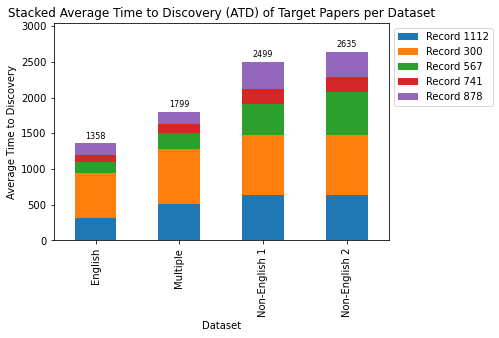

In [60]:
# ATD's of target papers per dataset
# Define the mapping dictionary for dataset renaming
dataset_mapping = {
    'Original': 'Multiple',
    'Multi_1': 'Non-English 1',
    'Multi_2': 'Non-English 2'
}

# Group by the desired factor and calculate the mean of 'td' values
grouped_df = metrics_df.groupby('Dataset')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

# Sort the grouped DataFrame by the average 'td' values in ascending order
grouped_df = grouped_df.reindex(grouped_df.mean(axis=1).sort_values().index)

# Set the factor you want to group by (e.g., 'Dataset', 'Prior Knowledge', 'Classifier')
group_by_factor = 'Dataset'

# Create the stacked bar chart
ax = grouped_df.plot.bar(stacked=True)

# Set the x-axis label
plt.xlabel(group_by_factor)

# Set the y-axis label
plt.ylabel('Average Time to Discovery')

# Modify the legend labels
legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']
ax.legend(labels=legend_labels, bbox_to_anchor=(1, 1))

# Rename the datasets on the x-axis
new_labels = [dataset_mapping.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)

# Set the title for the plot
plt.title("Stacked Average Time to Discovery (ATD) of Target Papers per Dataset")

# Add the sum of the entire bar on top
for i, value in enumerate(grouped_df.values):
    x = i
    y = value.sum()
    
    # Annotate the rounded sum value at the top of each bar
    ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                ha='center', va='bottom', fontsize=8, color='black')

# Adjust the y-axis limits
ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Show the plot
plt.show()

<ipython-input-56-322c7e60d033>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby(group)['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


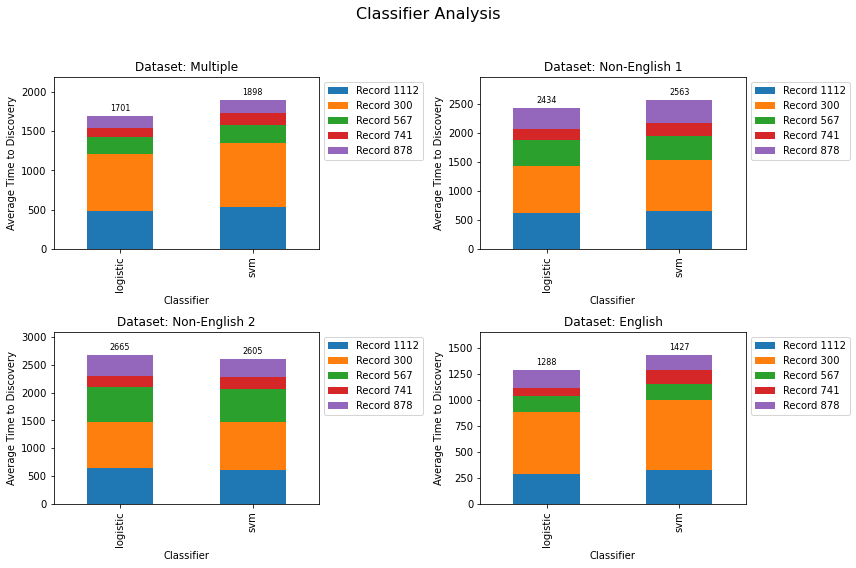

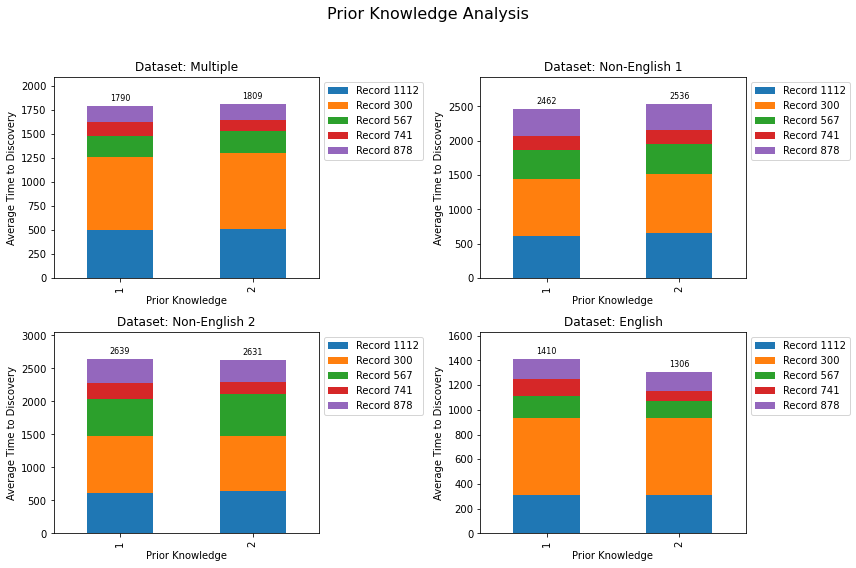

In [56]:
#ATD's per classifier and prior knowledge combination
groups = ['Classifier', 'Prior']

# Iterate over each group
for group in groups:
    # Create a new figure for each group
    fig = plt.figure(figsize=(12, 8))

    for i, dataset in enumerate(datasets):
        # Select the data for the current dataset
        df = metrics_df.loc[metrics_df.Dataset == dataset]

        # Group by the desired factor and calculate the mean of 'td' values
        grouped_df = df.groupby(group)['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

        # Set the factor you want to group by (e.g., Prior Knowledge', 'Classifier')
        group_by_factor = group

        # Create the subplot for the current dataset
        ax = fig.add_subplot(2, 2, i + 1)

        # Create the stacked bar chart
        grouped_df.plot.bar(stacked=True, ax=ax)

        # Set the x-axis label
        if group_by_factor == 'Prior':
            ax.set_xlabel('Prior Knowledge')
        else:
            ax.set_xlabel(group_by_factor)

        # Set the y-axis label
        ax.set_ylabel('Average Time to Discovery')

        # Modify the legend labels
        legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']
        ax.legend(labels=legend_labels, bbox_to_anchor=(1, 1))

        # Set the title for each plot
        if dataset == 'Original':
            dataset_title = 'Multiple'
        elif dataset == 'Multi_1':
            dataset_title = 'Non-English 1'
        elif dataset == 'Multi_2':
            dataset_title = 'Non-English 2'
        else:
            dataset_title = dataset
        ax.set_title(f"Dataset: {dataset_title}")
        
        # Add the sum of the entire bar on top
        for i, value in enumerate(grouped_df.values):
            x = i
            y = value.sum()

            # Annotate the rounded sum value at the top of each bar
            ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8, color='black')
            
        # Adjust the y-axis limits
        ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

    # Set the title for the figure
    if group_by_factor == 'Prior':
        fig.suptitle(f"{group} Knowledge Analysis", fontsize=16)
    else:
        fig.suptitle(f"{group} Analysis", fontsize=16)

    # Adjust the spacing between subplots
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()

<ipython-input-69-691330116205>:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = metrics_df.groupby(['Dataset', group])['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


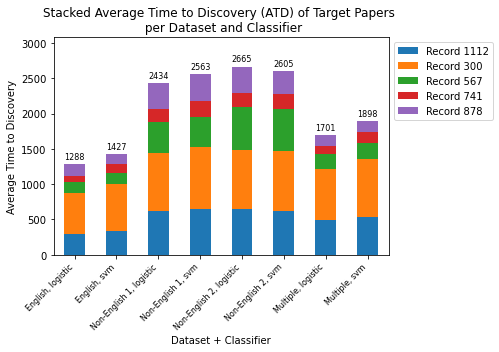

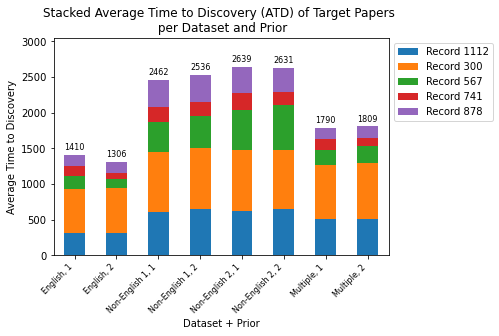

In [69]:
import matplotlib.pyplot as plt

# Define the mapping dictionary for dataset renaming
dataset_mapping = {
    'Original': 'Multiple',
    'Multi_1': 'Non-English 1',
    'Multi_2': 'Non-English 2'
}

groups = ['Classifier', 'Prior']

for group in groups:
    # Group by the desired factor and calculate the mean of 'td' values
    grouped_df = metrics_df.groupby(['Dataset', group])['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

    # Set the factor you want to group by (e.g., 'Dataset', 'Prior Knowledge', 'Classifier')
    group_by_factor = 'Dataset'

    # Create the stacked bar chart
    ax = grouped_df.plot.bar(stacked=True)

    # Set the x-axis label
    plt.xlabel(group_by_factor + ' + ' + group)

    # Set the y-axis label
    plt.ylabel('Average Time to Discovery')

    # Modify the legend labels
    legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']
    ax.legend(labels=legend_labels, bbox_to_anchor=(1, 1))

    # Update the dataset labels on the x-axis to include prior knowledge
    x_pos = range(len(grouped_df))
    xticklabels = [
        f"{dataset_mapping.get(dataset, dataset)}, {prior.split('_')[-1]}"
        for (dataset, prior), i in zip(grouped_df.index, x_pos)
    ]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right', fontsize=8)

    # Set the title for the plot
    plt.title("Stacked Average Time to Discovery (ATD) of Target Papers \n per Dataset and " + group)

    # Add the sum of the entire bar on top
    for i, value in enumerate(grouped_df.values):
        x = i
        y = value.sum()

        # Annotate the rounded sum value at the top of each bar
        ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8, color='black')

    # Adjust the y-axis limits
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

    # Show the plot
    plt.show()

<ipython-input-89-f62681537ab9>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_df = df.groupby('Model')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()


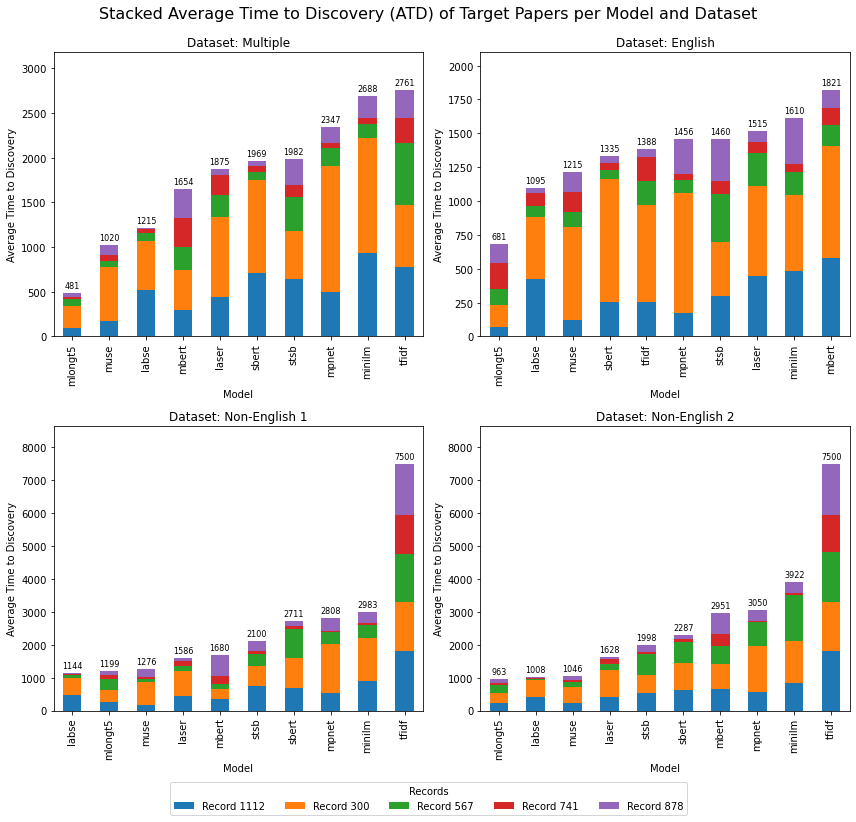

In [89]:
# ATD's per model per dataset
# Create a new figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Iterate over each dataset
for i, dataset in enumerate(datasets):
    # Select the data for the current dataset
    df = metrics_df.loc[metrics_df.Dataset == dataset]

    # Group by the desired factor and calculate the mean of 'td' values
    grouped_df = df.groupby('Model')['td_1112', 'td_300', 'td_567', 'td_741', 'td_878'].mean()

    # Sort the grouped DataFrame by the average 'td' values in ascending order (only for 'Model' group)
    grouped_df = grouped_df.reindex(grouped_df.mean(axis=1).sort_values().index)

    # Create the stacked bar chart for the current dataset
    ax = axes[i // 2, i % 2]
    grouped_df.plot.bar(stacked=True, ax=ax)

    # Set the x-axis label
    ax.set_xlabel('Model')

    # Set the y-axis label
    ax.set_ylabel('Average Time to Discovery')

    # Set the title for each plot
    if dataset == 'Original':
        dataset_title = 'Multiple'
    elif dataset == 'Multi_1':
        dataset_title = 'Non-English 1'
    elif dataset == 'Multi_2':
        dataset_title = 'Non-English 2'
    else:
        dataset_title = dataset
    ax.set_title(f"Dataset: {dataset_title}")

    # Add the sum of the entire bar on top
    for j, value in enumerate(grouped_df.values):
        x = j
        y = value.sum()

        # Annotate the rounded sum value at the top of each bar
        ax.annotate(f'{int(round(y))}', (x, y), xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom', fontsize=8, color='black')

    # Adjust the y-axis limits
    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

# Set the title for the figure
fig.suptitle("Stacked Average Time to Discovery (ATD) of Target Papers per Model and Dataset", fontsize=16)

# Remove legends from subplots
for ax in axes.flatten():
    ax.legend().remove()

# Modify the legend labels
legend_labels = ['Record 1112', 'Record 300', 'Record 567', 'Record 741', 'Record 878']

# Create a common legend underneath the subplots
fig.legend(labels=legend_labels, loc='lower center', title='Records', ncol=5, bbox_to_anchor=(0.5, -0.15))

# Adjust the spacing between subplots and legend
fig.tight_layout(rect=[0, -0.1, 1, 0.99])

# Show the plot
plt.show()

## Recall Plots

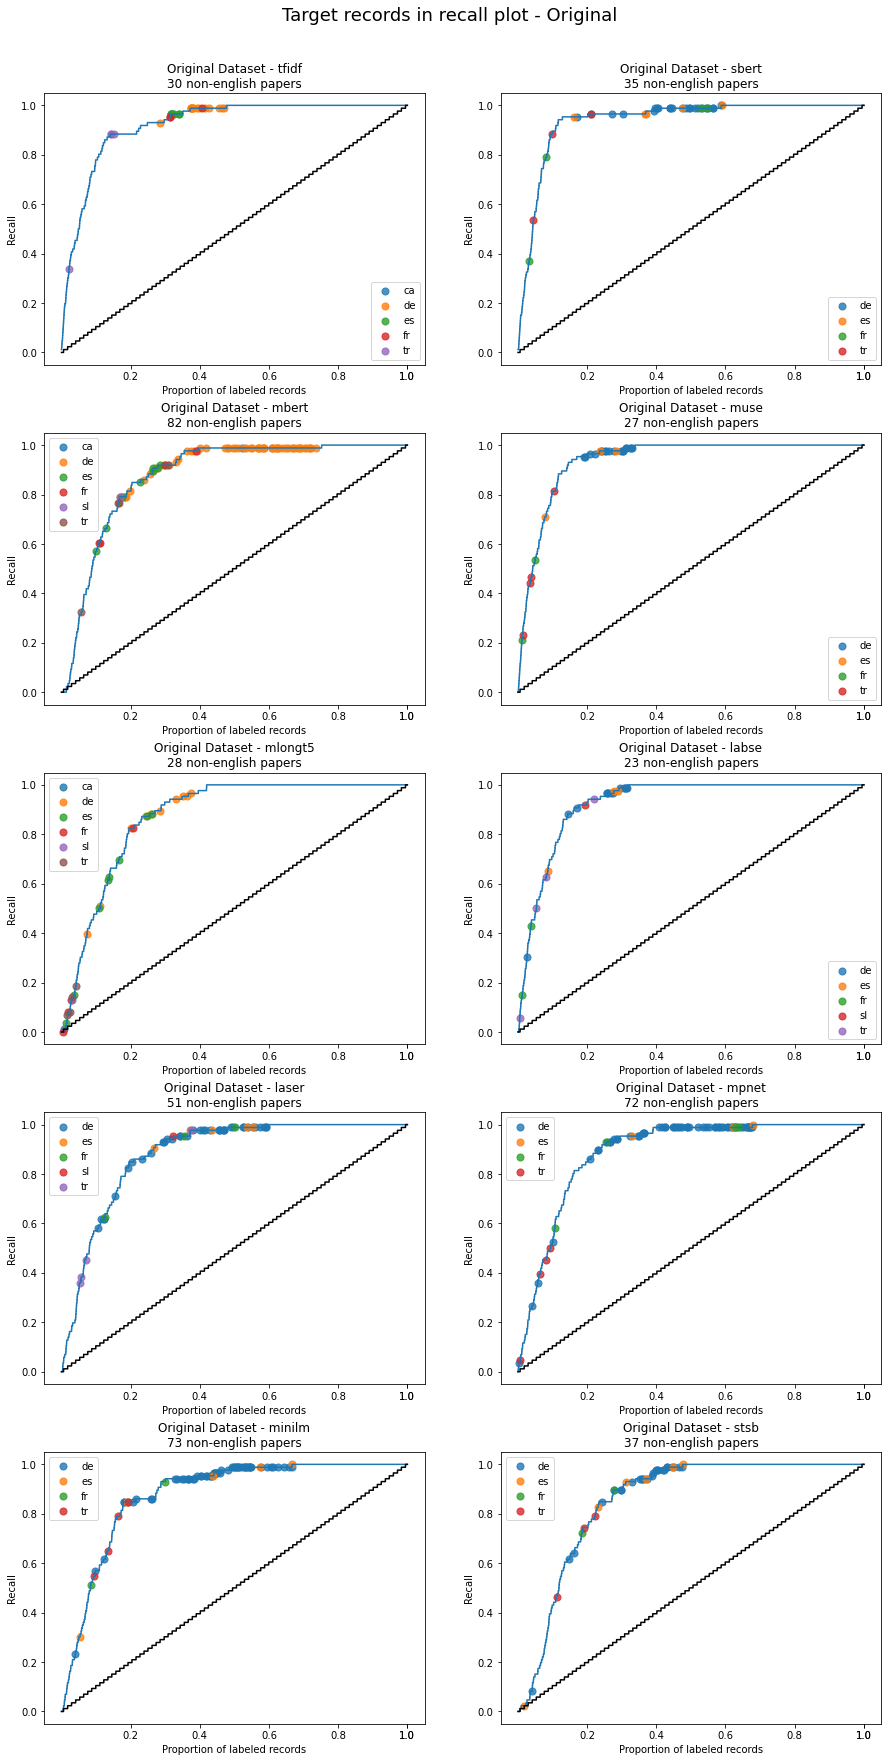

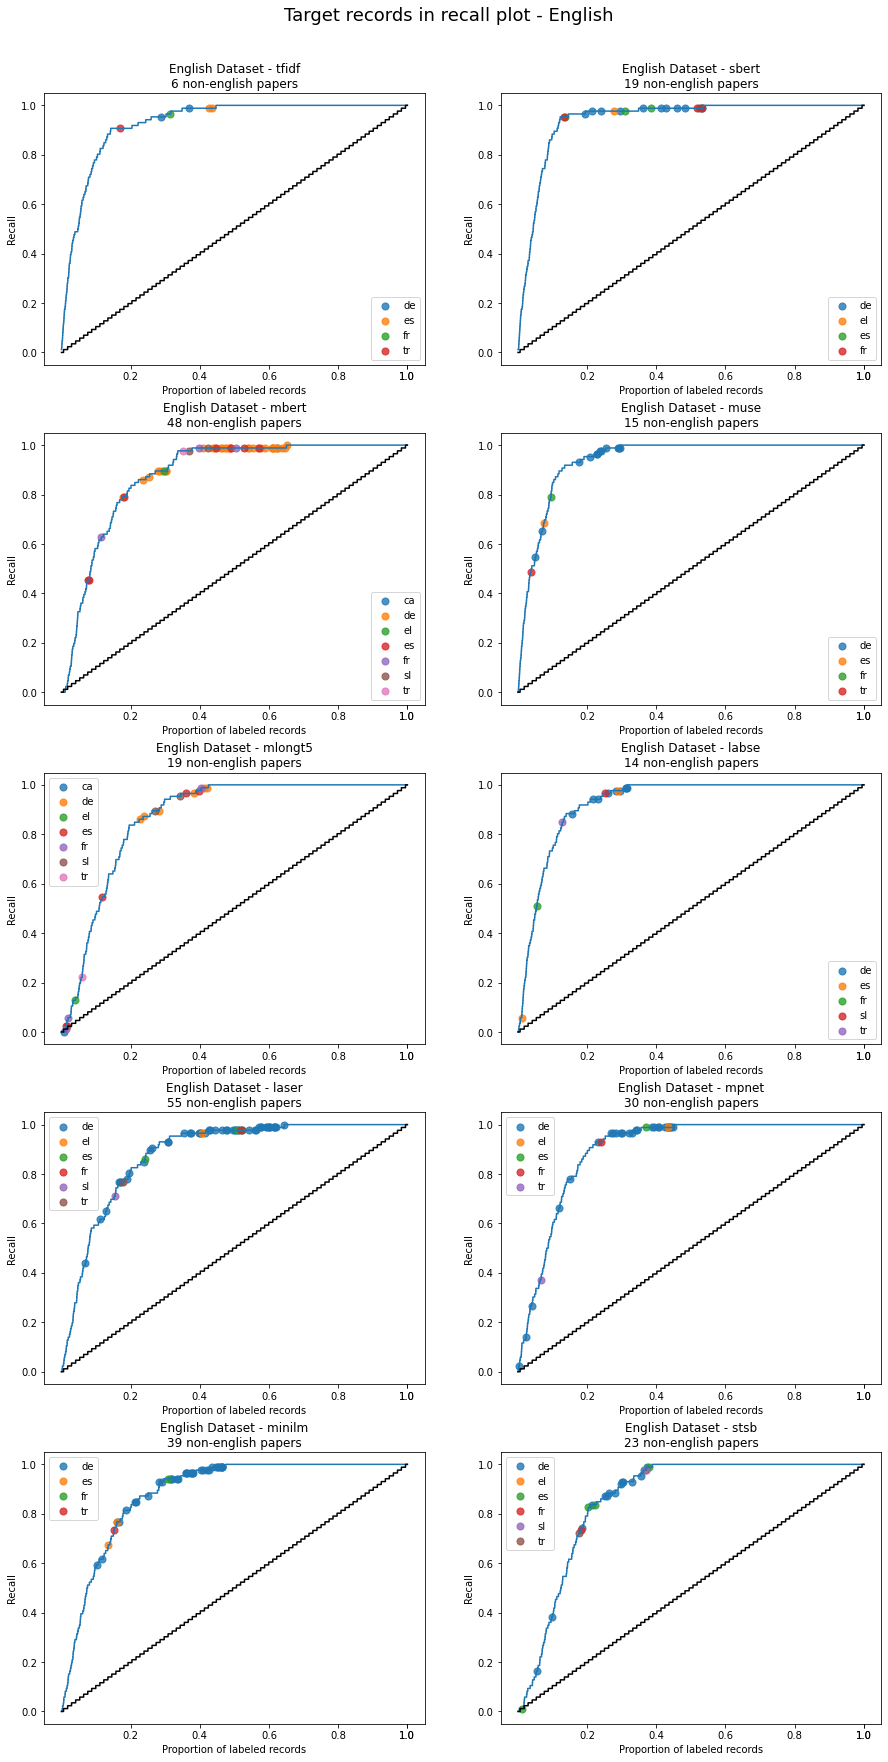

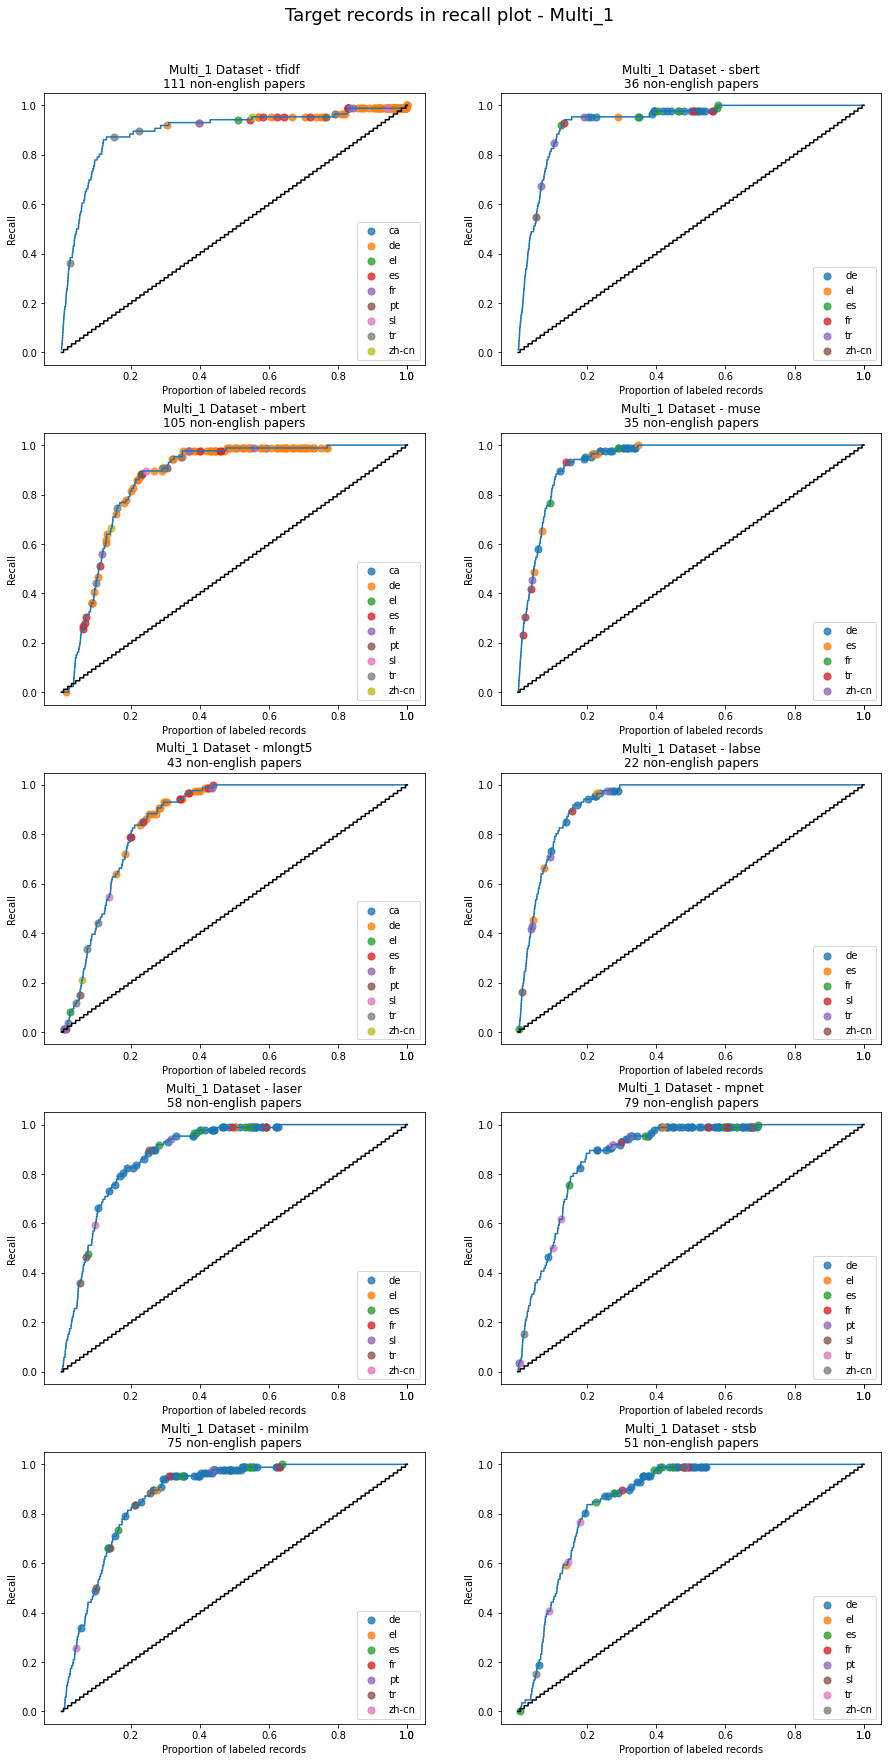

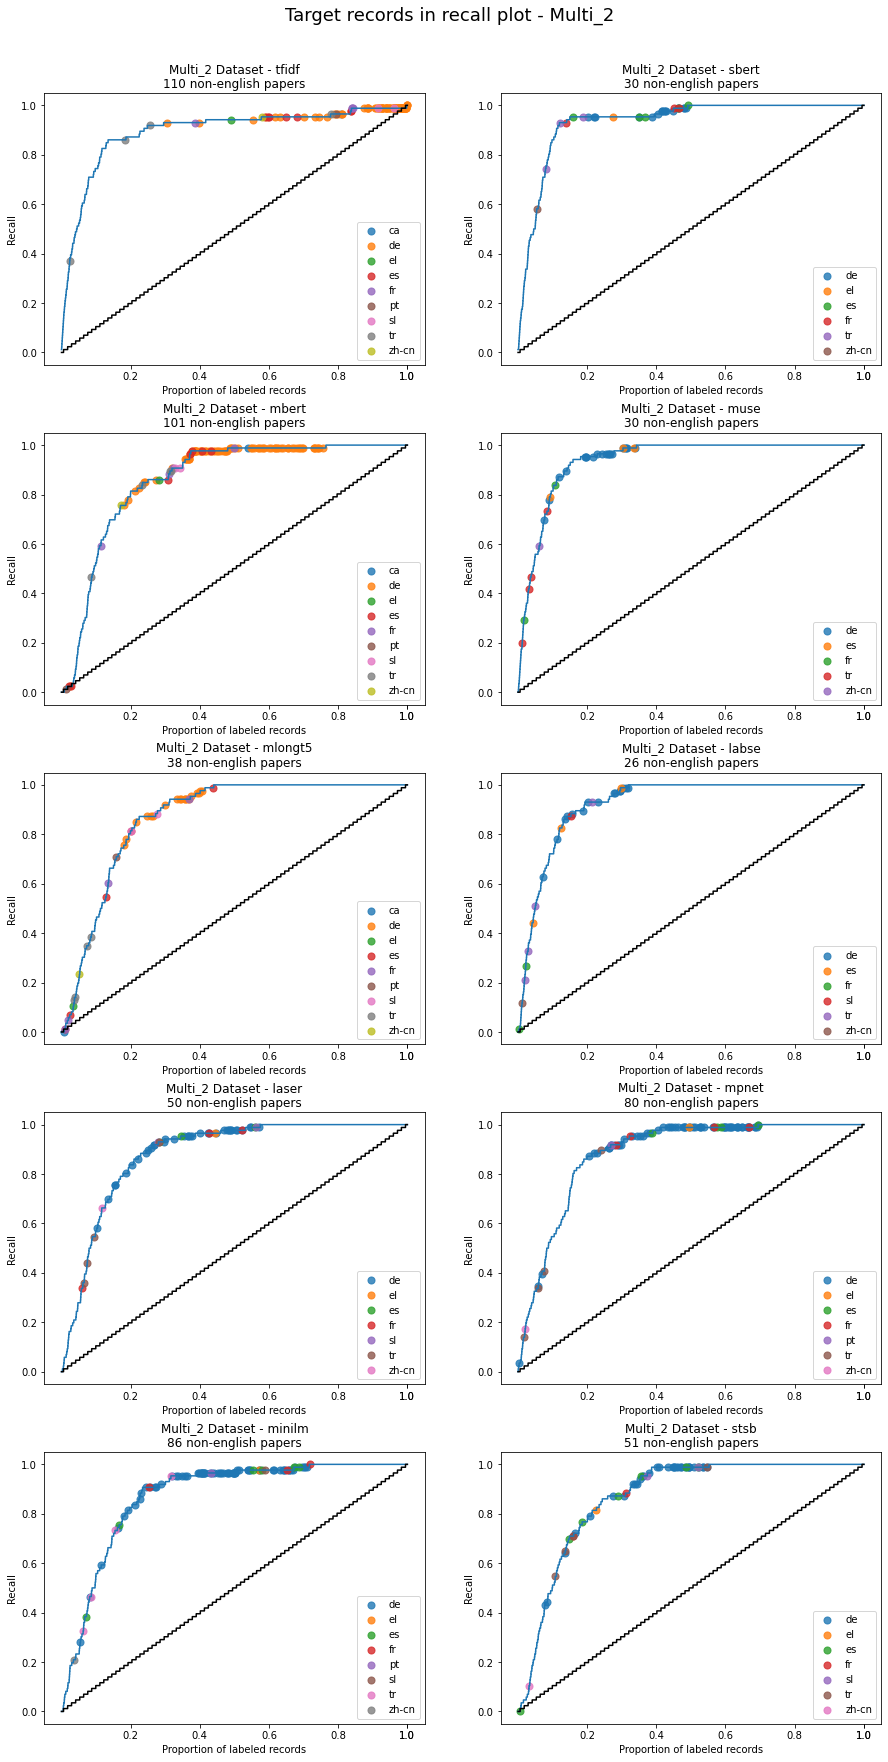

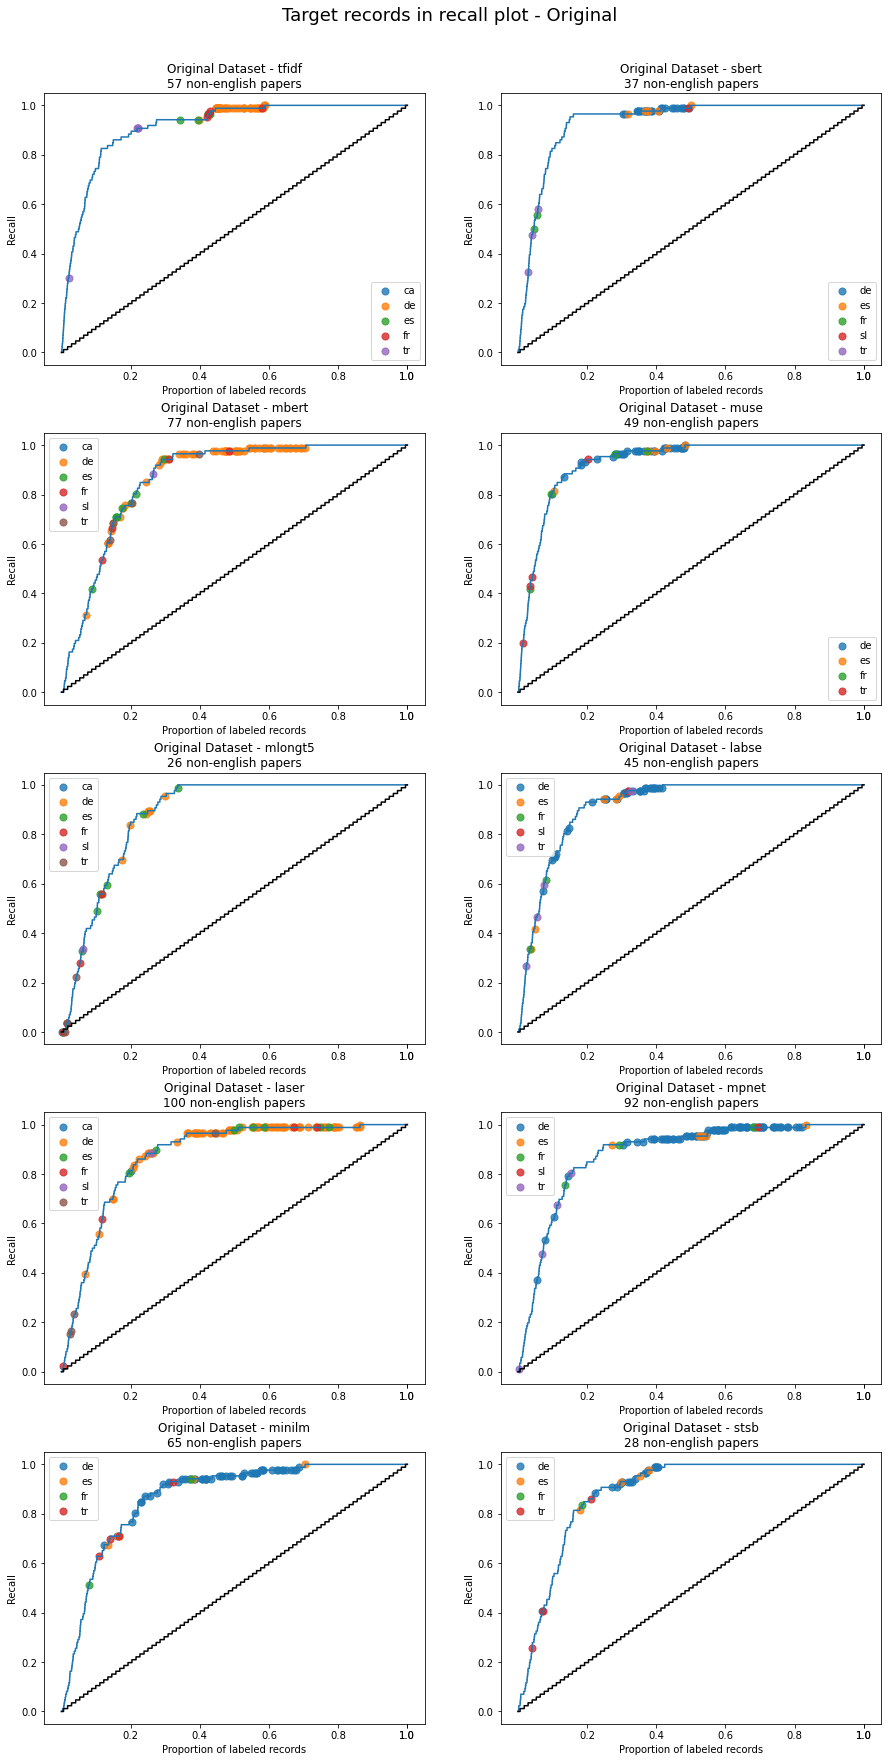

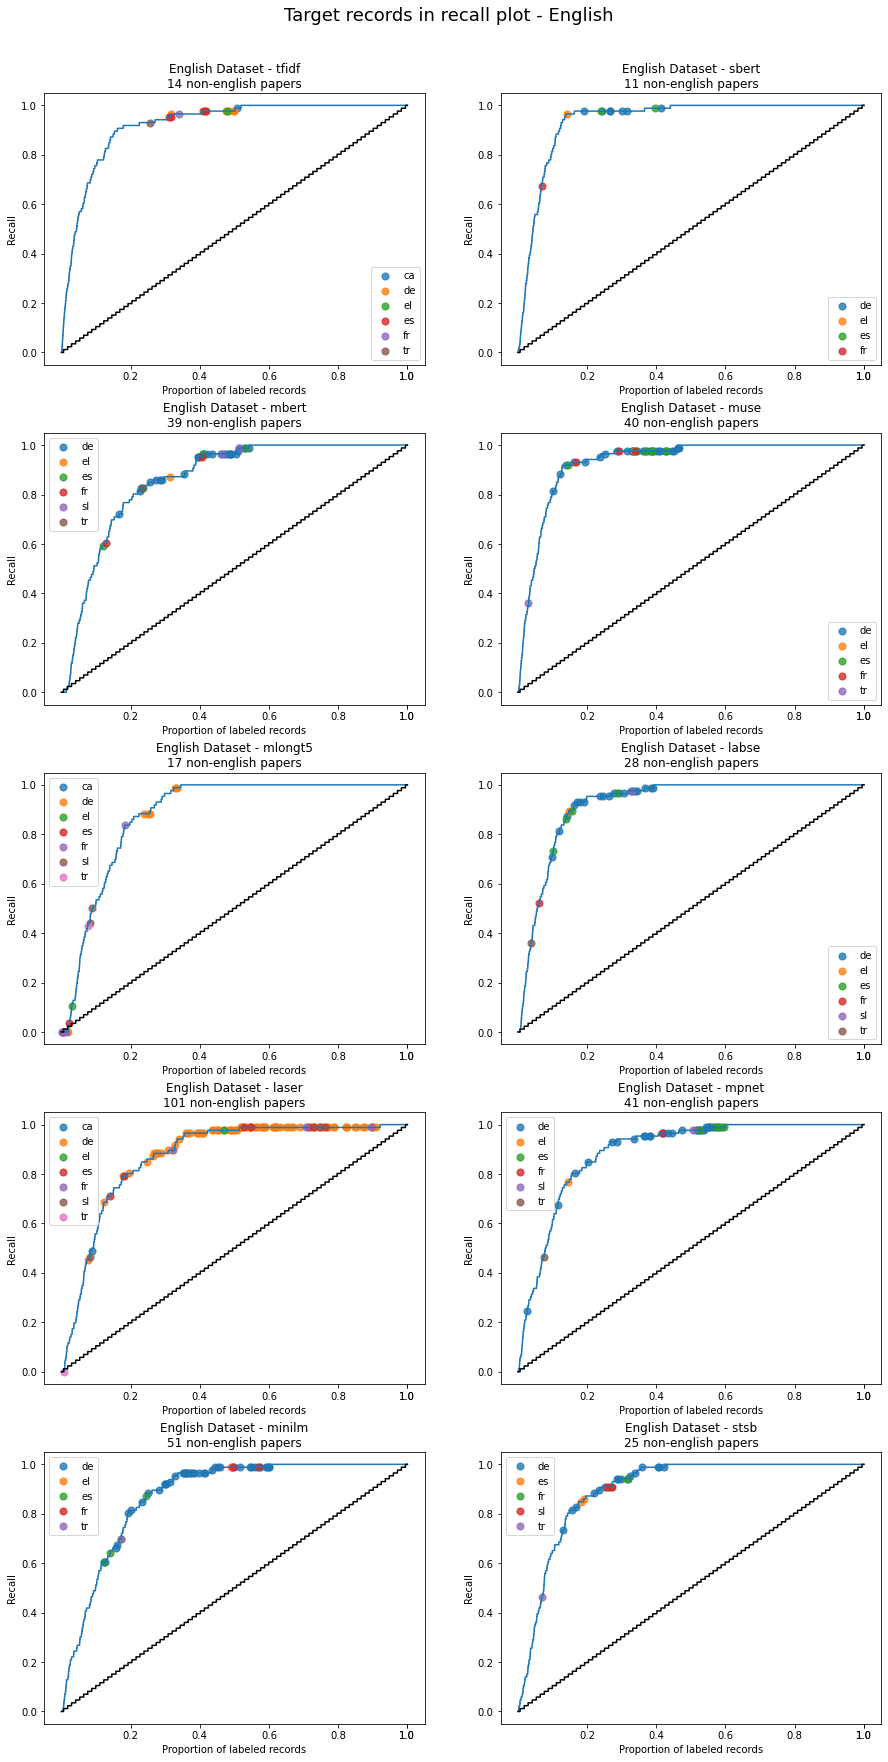

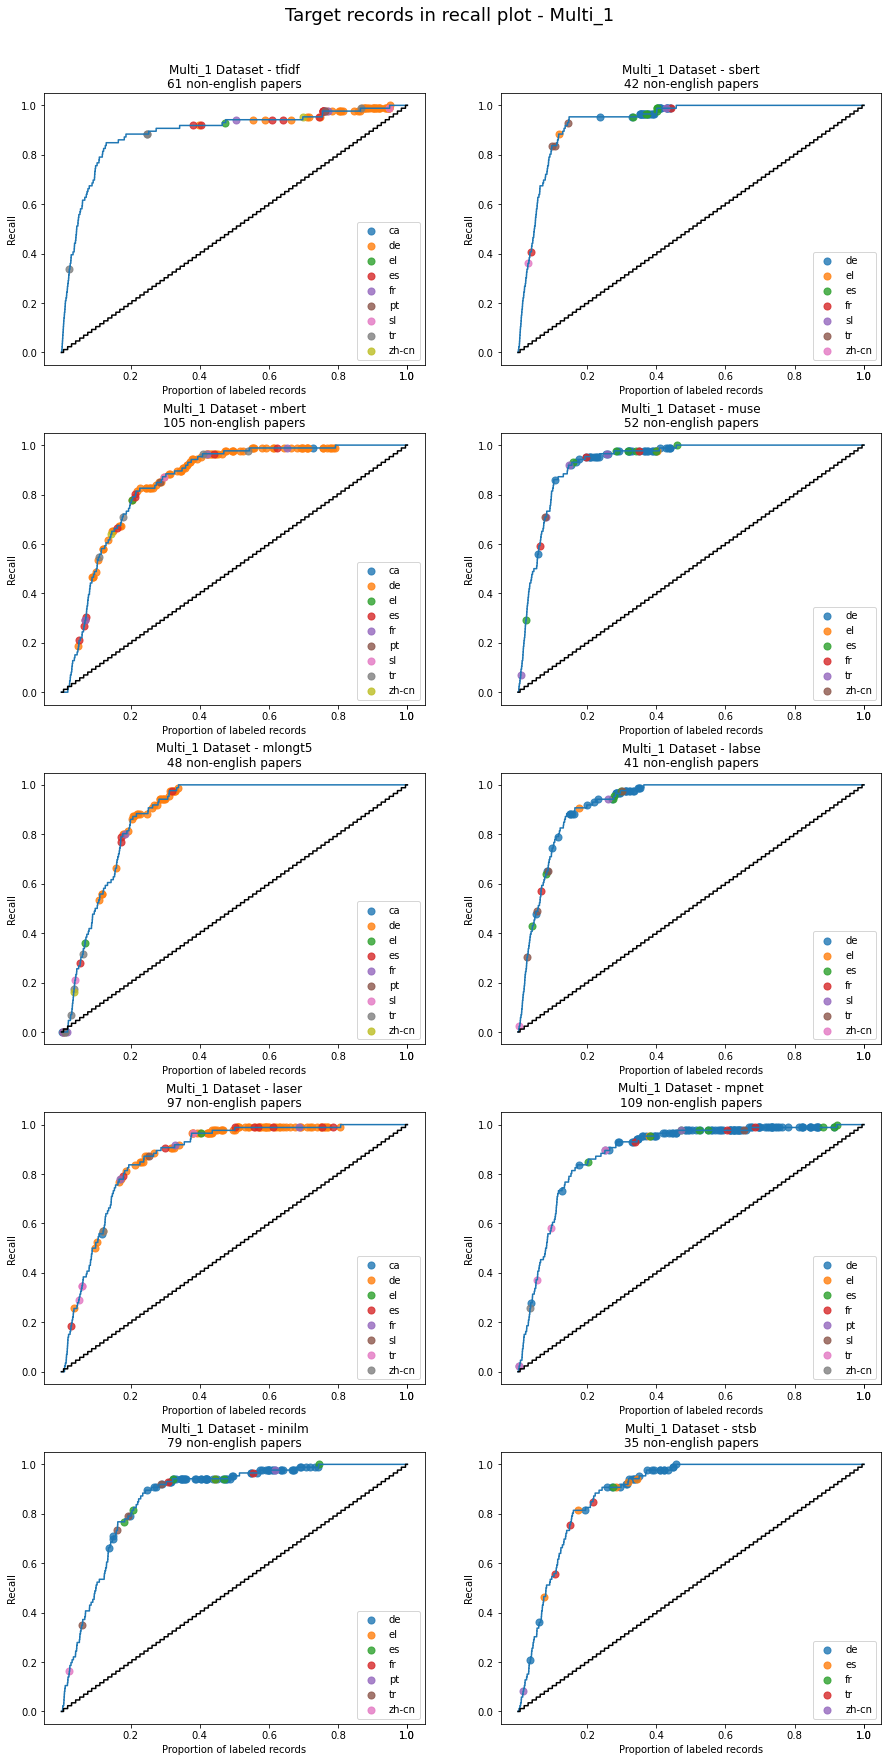

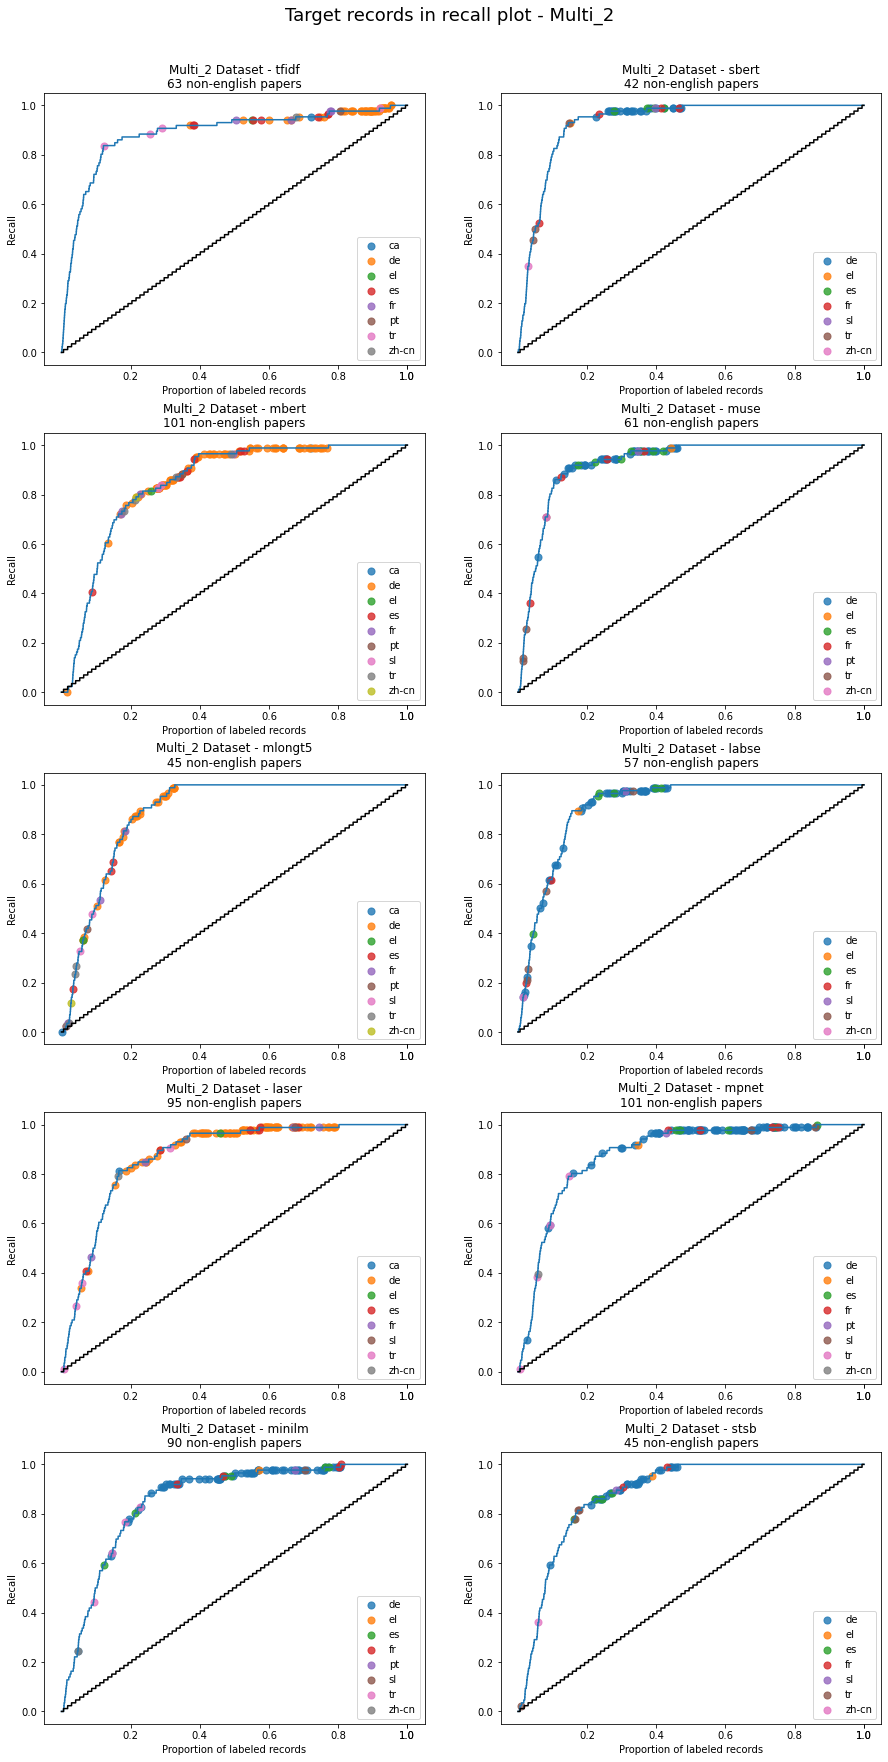

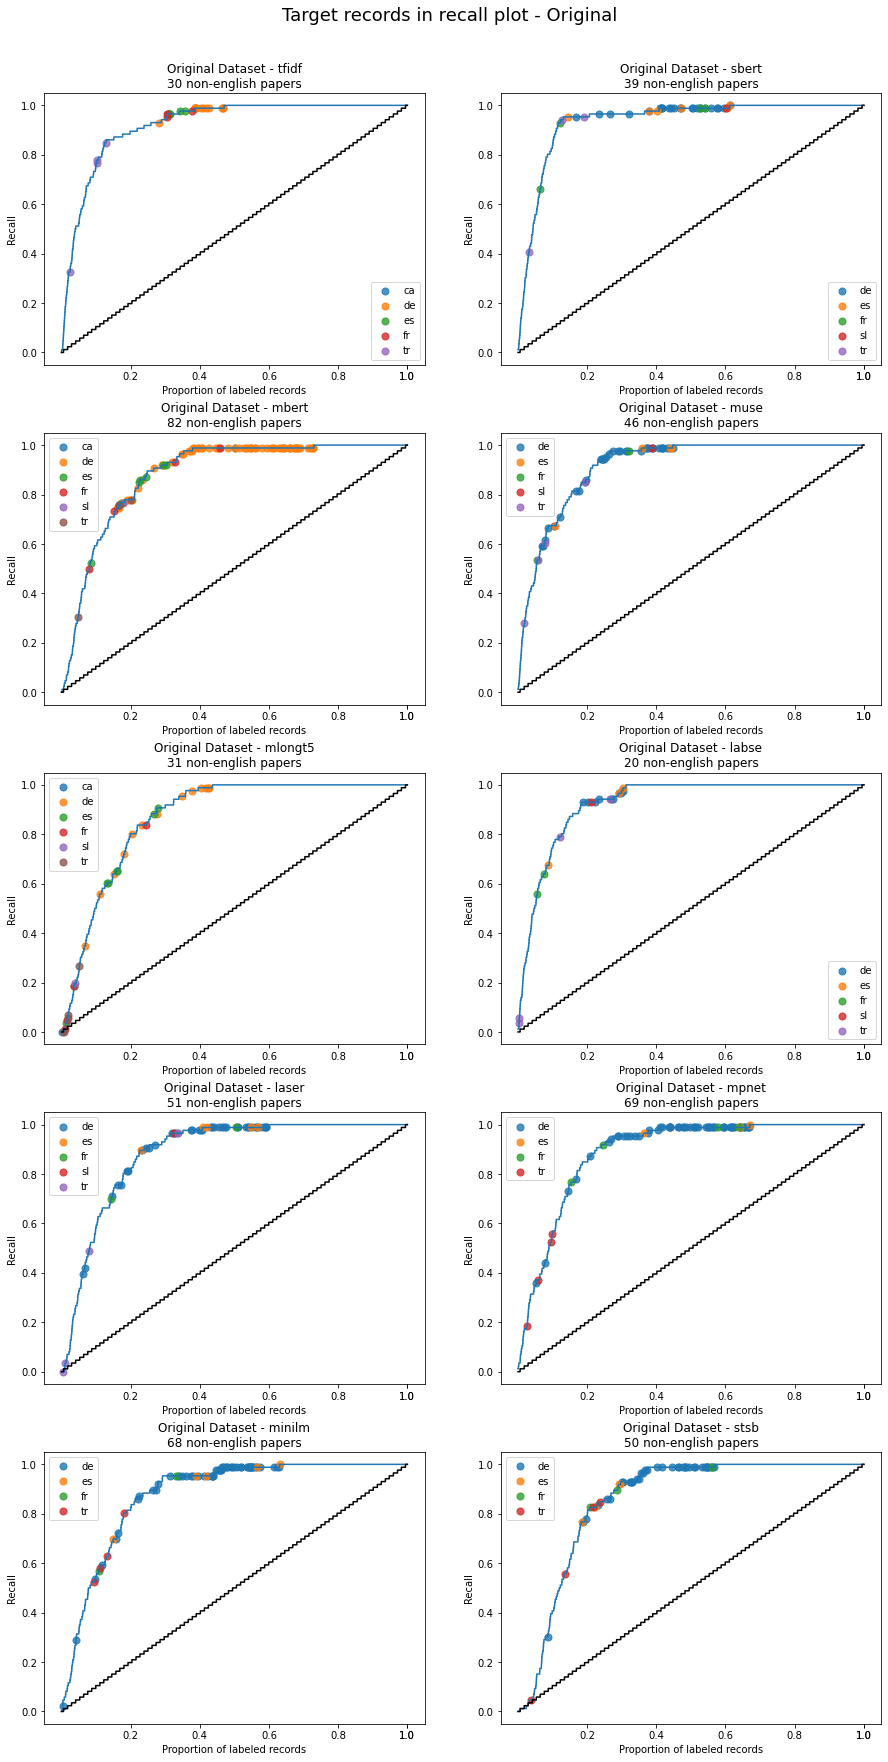

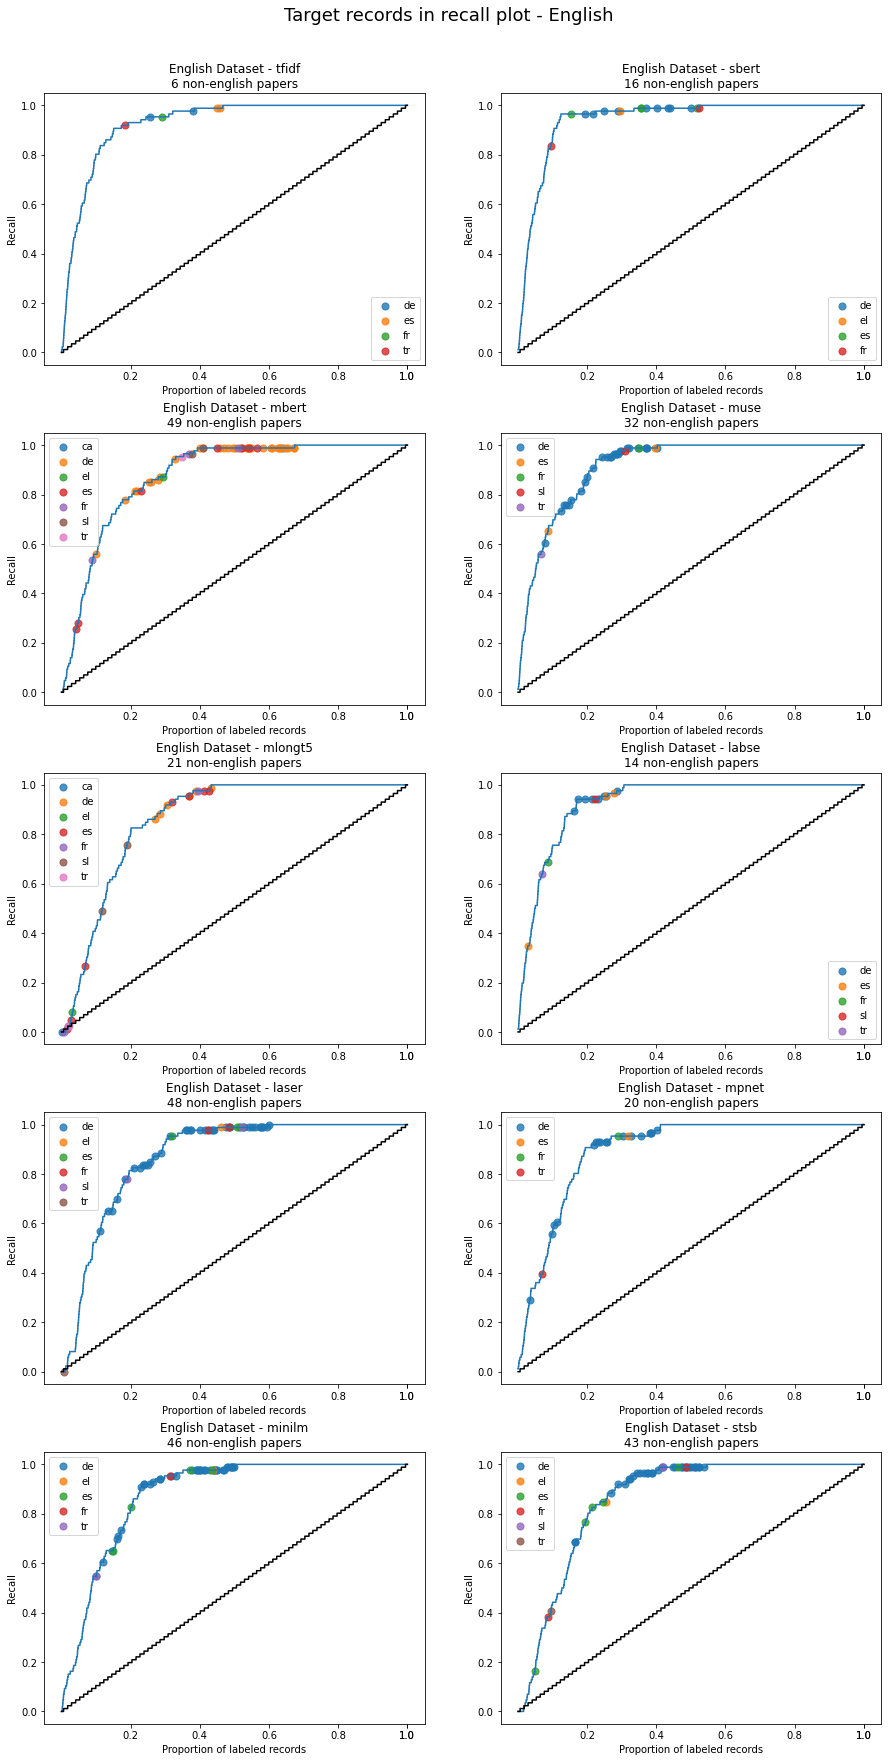

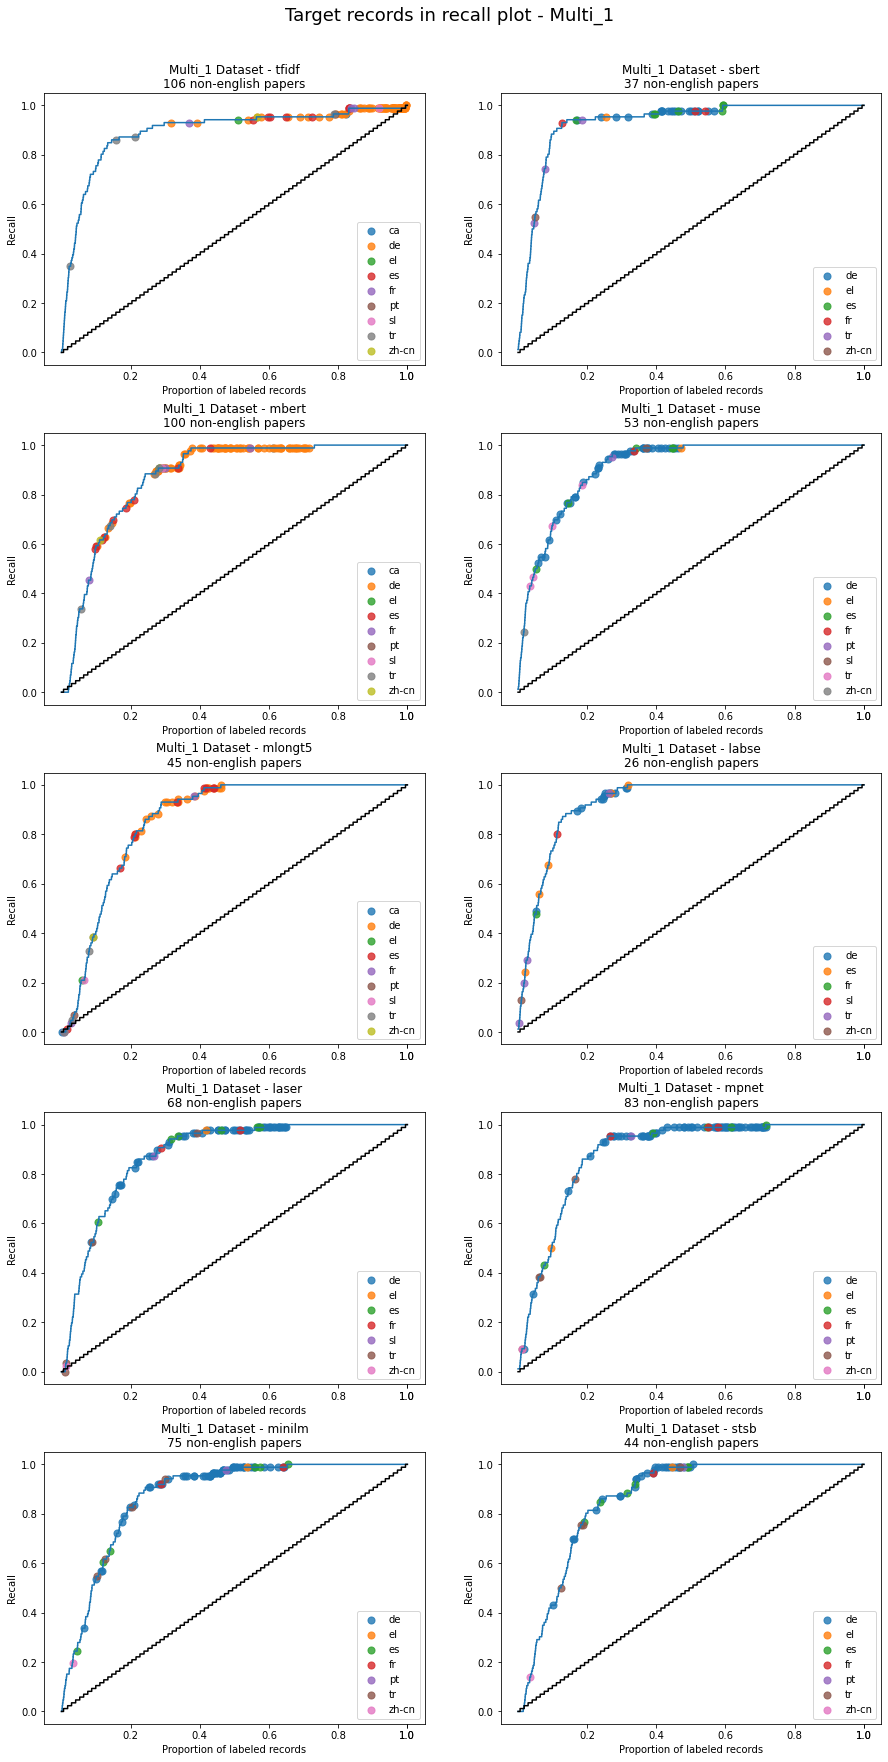

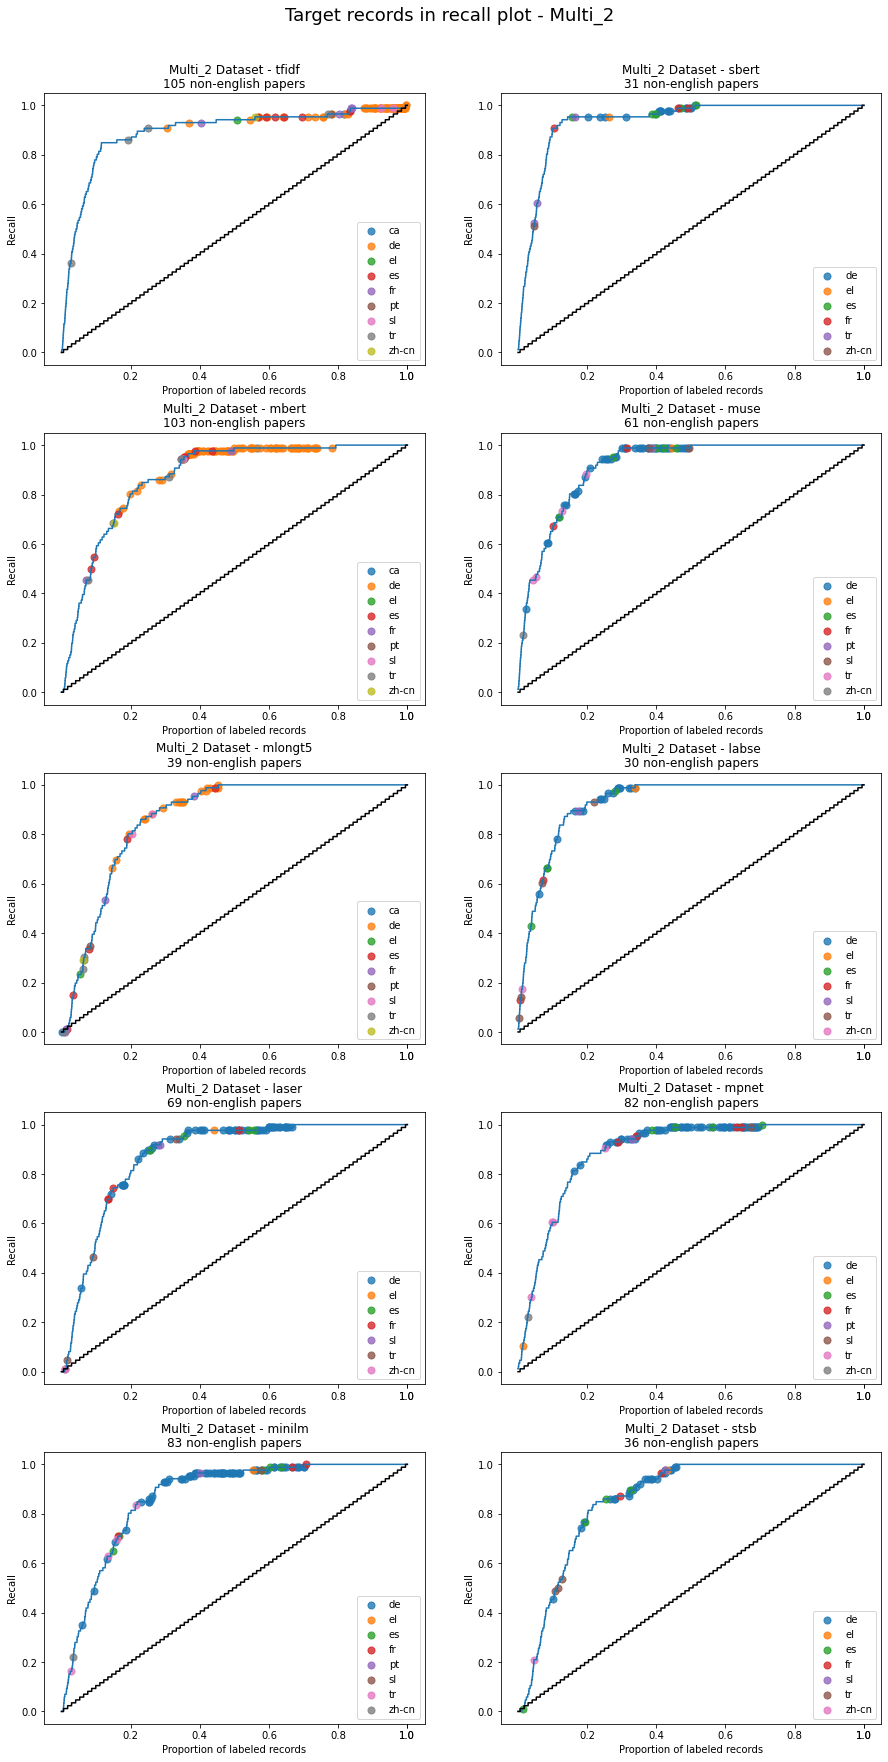

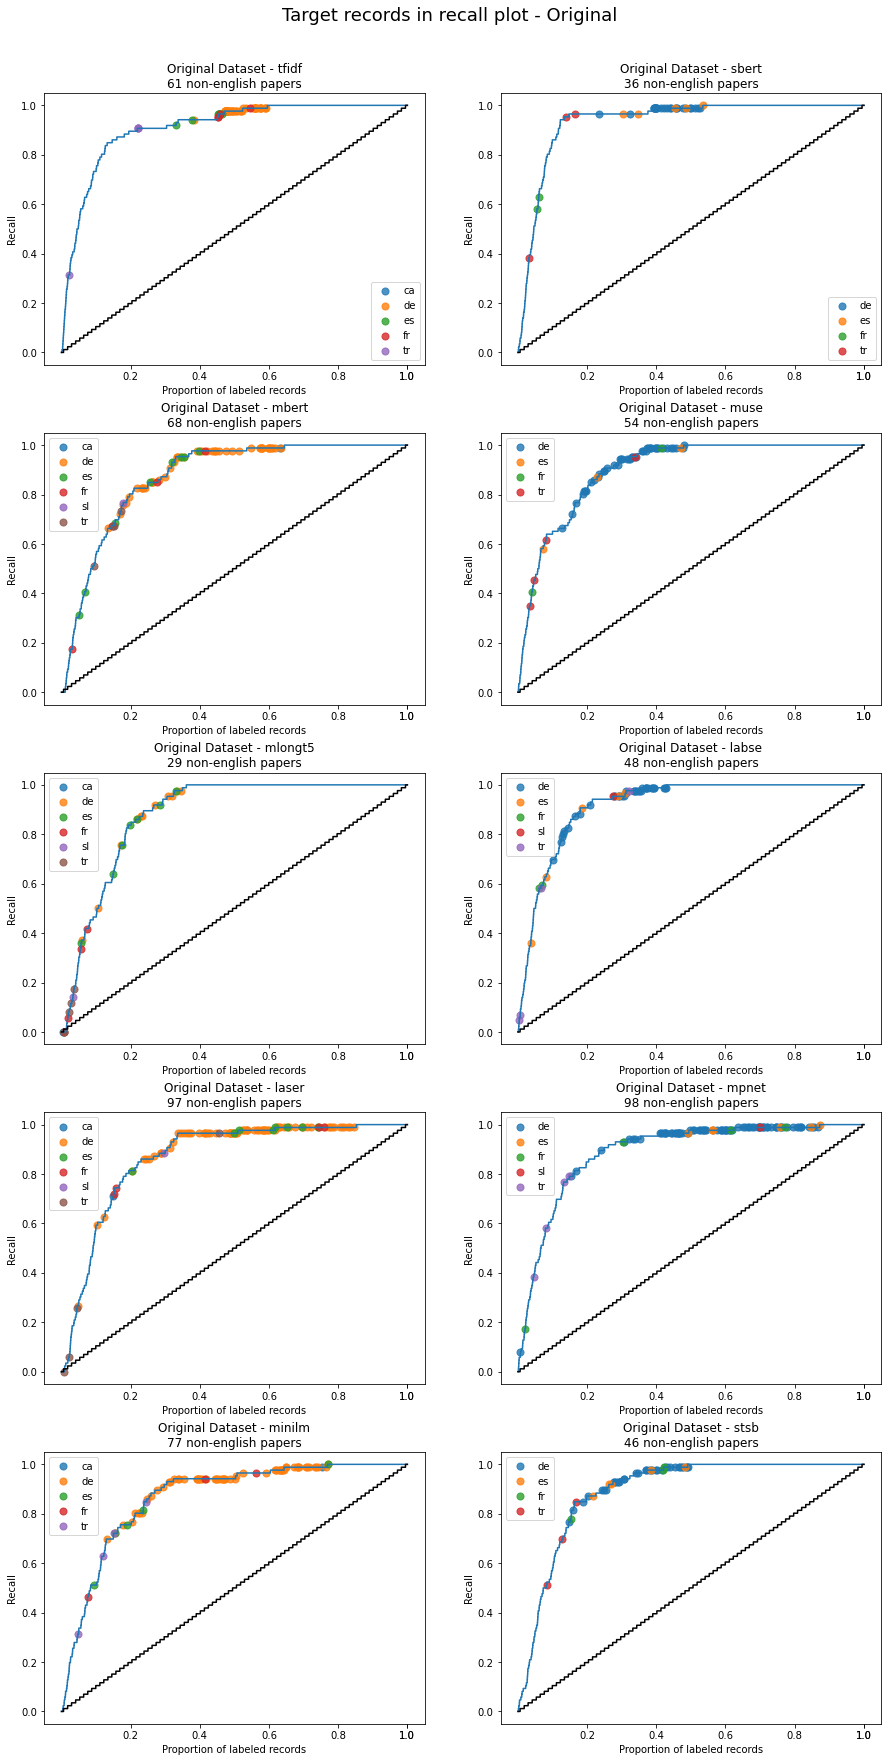

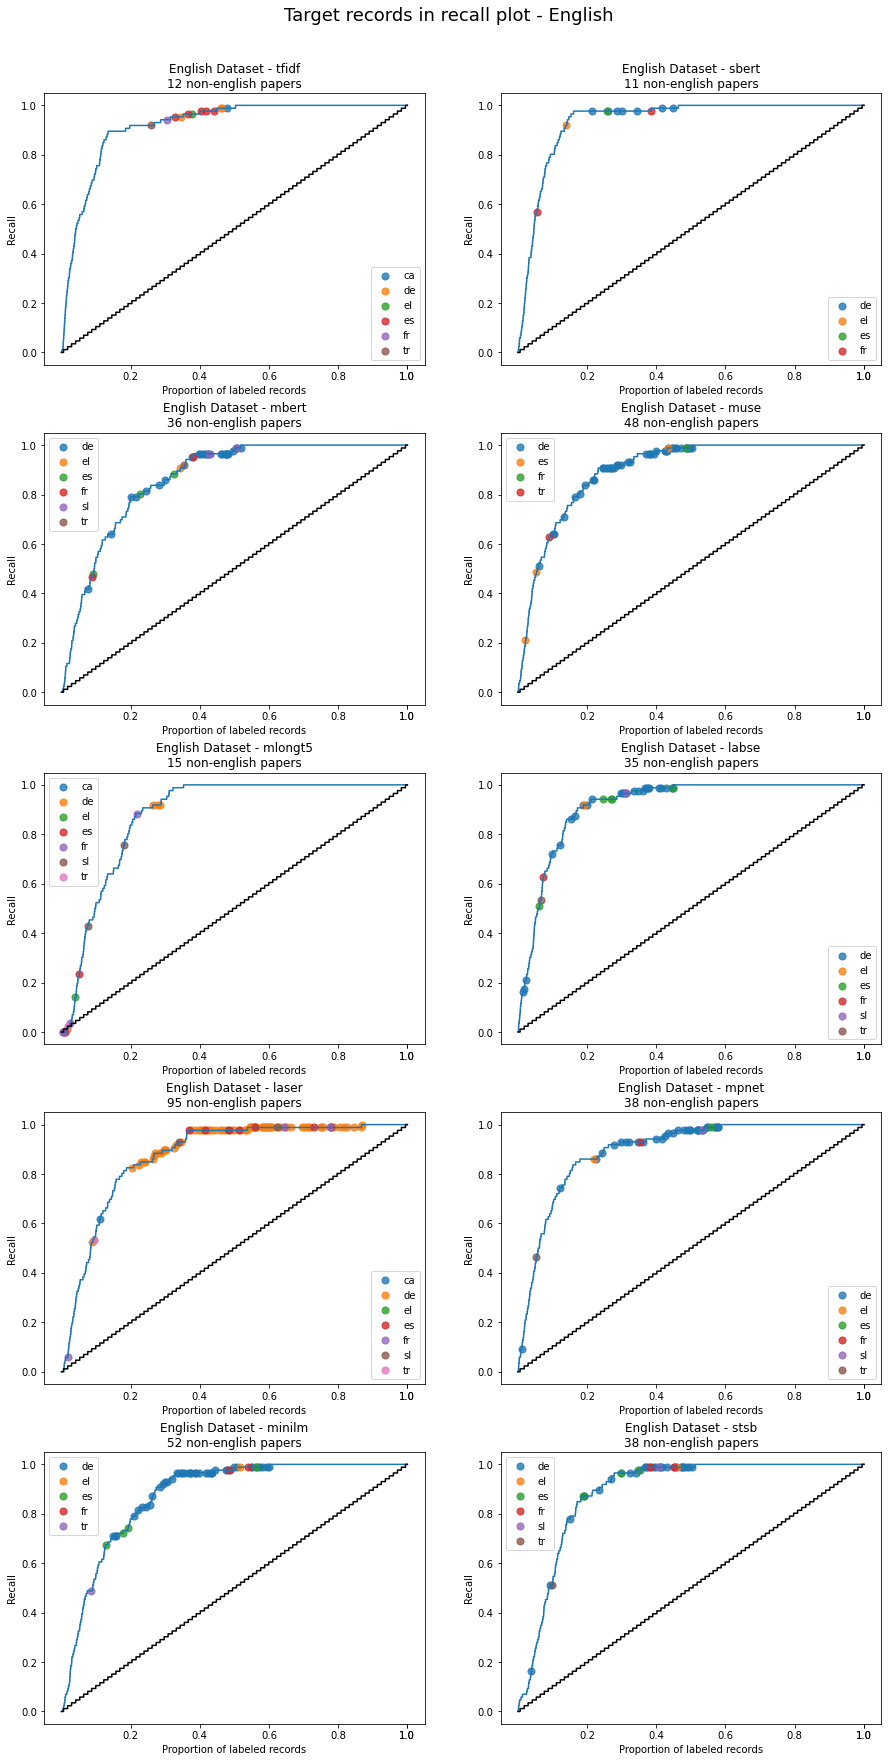

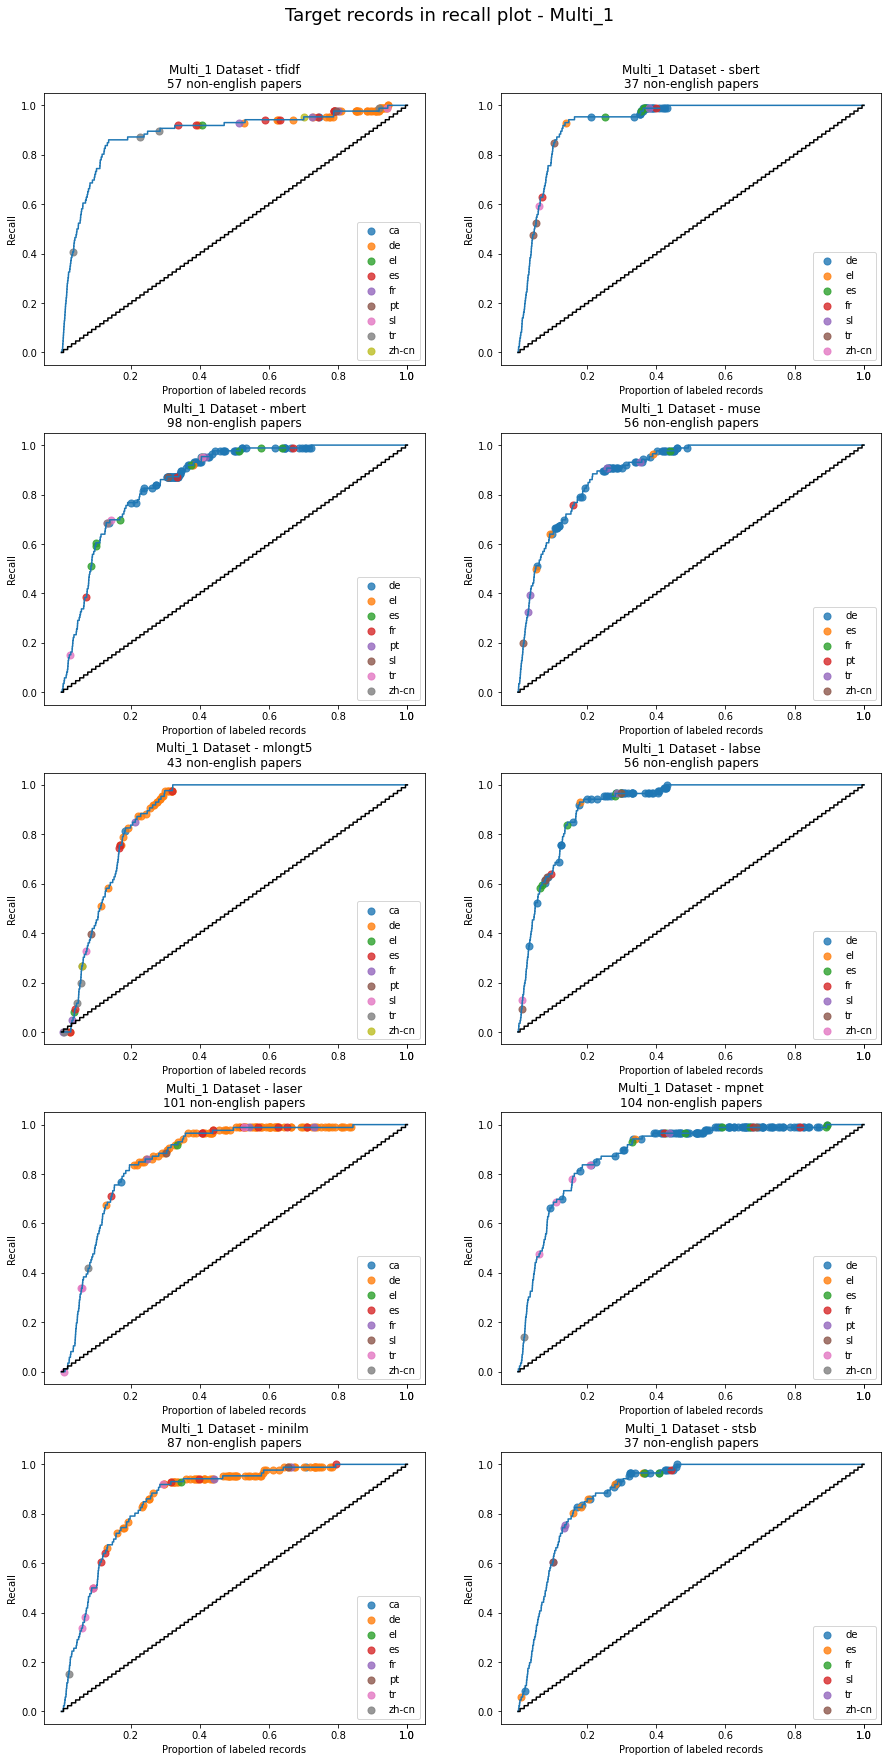

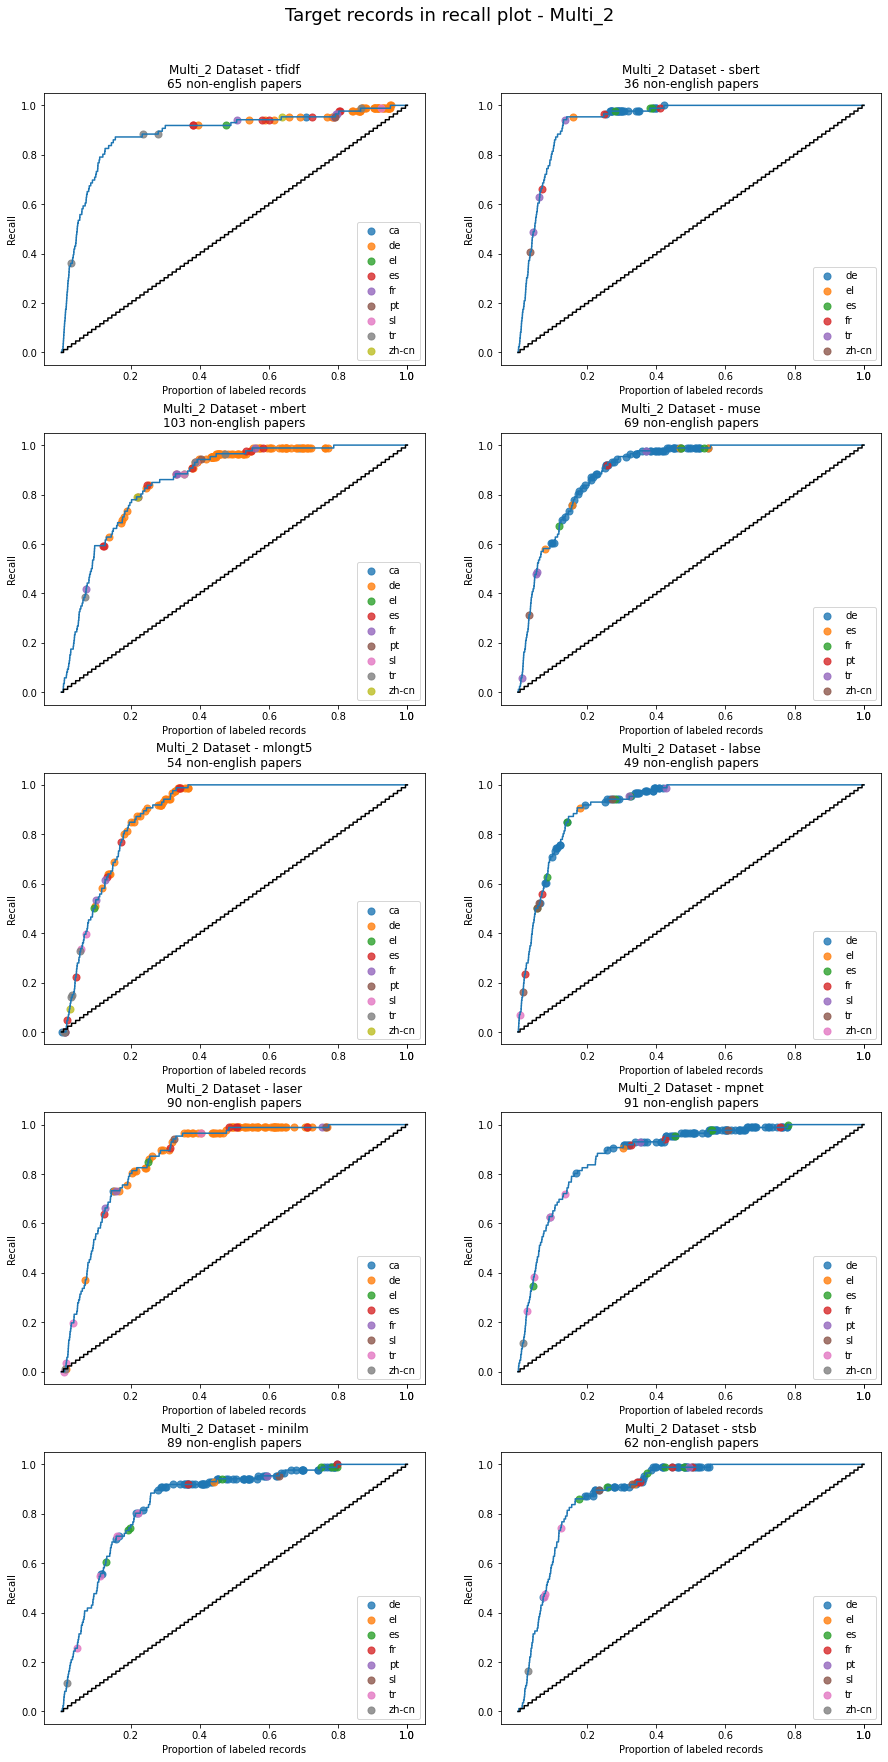

In [90]:
for prior in prior_knowledge:
    for classifier in classifiers:    
        for dataset in datasets:
            plt.figure(figsize=(15, 30))
            plt.subplots_adjust(hspace=0.25)
            plt.suptitle("Target records in recall plot - "+ dataset, fontsize=18, y=0.92)
            n=0
            for model in models:
                ax = plt.subplot(5, 2, n + 1)
                with open_state(state_files.format(prior, dataset, classifier, model)) as state:
                    states_df = state.get_dataset()

                    sim_labels = pad_simulation_labels(state)
                    x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)

                    languages = language_dfs[dataset]
                    states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
                    non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False))]

                    #print(non_english.language.head().sort_values().unique())

                    for language in non_english.language.sort_values().unique():
                        temp = non_english.loc[non_english.language==language]
                        ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", alpha=0.8, s=50)
                    ax.legend(non_english.language.sort_values().unique())

                    #draw the plot
                    plot_recall(ax, state)

                    ax.set_title(dataset + " Dataset - " + model + '\n' + str(len(non_english)) + ' non-english papers')
                    n+=1

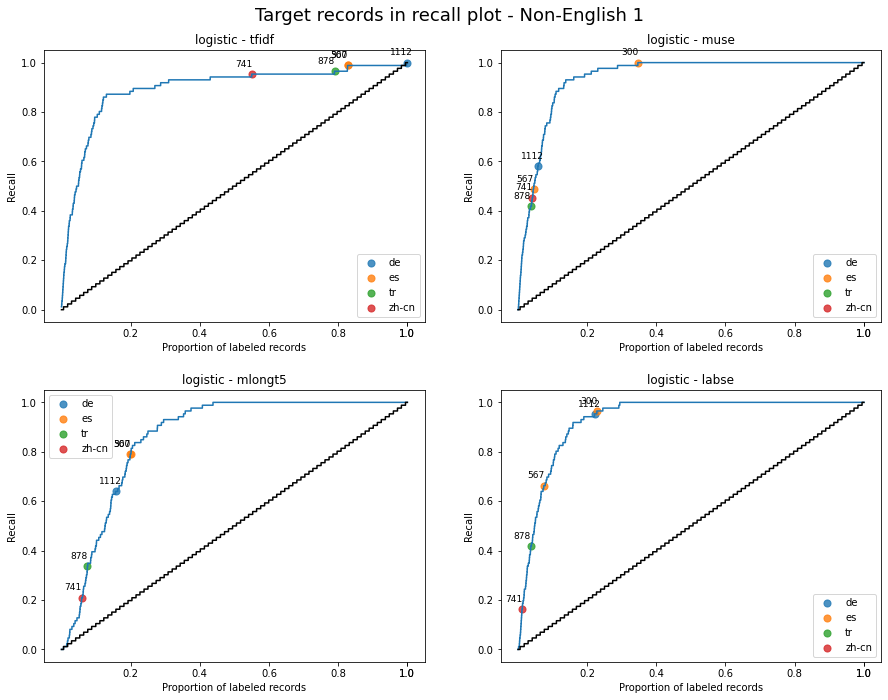

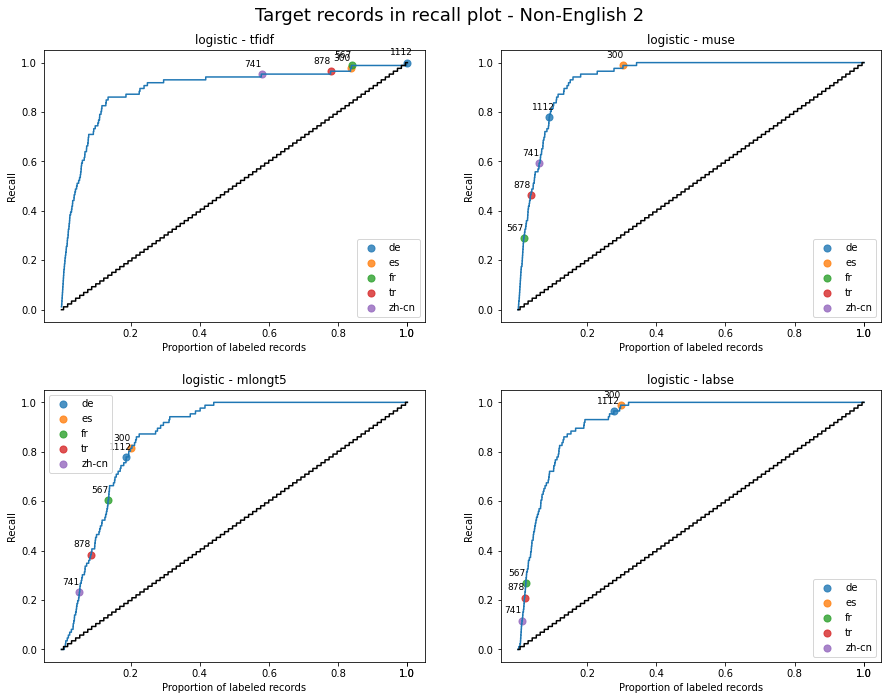

In [98]:
for prior in prior_knowledge[:1]:
    for classifier in classifiers[:1]:    
        for dataset in datasets[2:4]:
            plt.figure(figsize=(15, 30))
            plt.subplots_adjust(hspace=0.25)
            if dataset == 'Original':
                tit = 'Multiple'
            elif dataset == 'Multi_1':
                tit = 'Non-English 1'
            elif dataset == 'Multi_2':
                tit = 'Non-English 2'
            else:
                tit = 'English'
            plt.suptitle("Target records in recall plot - "+ tit, fontsize=18, y=0.90)
            n=0
            for model in [models[i] for i in [0, 3, 4, 5]]:
                ax = plt.subplot(5, 2, n + 1)
                with open_state(state_files.format(prior, dataset, classifier, model)) as state:
                    states_df = state.get_dataset()

                    sim_labels = pad_simulation_labels(state)
                    x, y = _recall_values(sim_labels, x_absolute=False, y_absolute=False)

                    languages = language_dfs[dataset]
                    states_df = states_df.merge(languages[['record_id', 'language']], on='record_id')
                    non_english = states_df.loc[((states_df.language != 'en') & (states_df.language.isna() == False)
                                                & (states_df.label == 1))]
                    targets = states_df.loc[states_df.record_id.isin([300, 567, 741, 878, 1112])]

                    for language in targets.language.sort_values().unique():
                        temp = targets.loc[targets.language==language]
                        ax.scatter([x[i] for i in temp.index], [y[i] for i in temp.index], marker="o", s=50, alpha=0.8)
                        for index, row in temp.iterrows():
                            ax.text(x[index]-0.05, y[index]+0.03, row.record_id, fontsize=9)
                    ax.legend(non_english.language.sort_values().unique())

                    #draw the plot
                    plot_recall(ax, state)

                    ax.set_title(classifier + ' - ' + model)
                    n+=1